<a href="https://colab.research.google.com/github/tmd03/DL/blob/main/DL_project_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/depression_dataset.csv')
df.head()

,clean_text,mental_status
0,switchfoot http twitpic com y zl awww that s a...,0
1,is upset that he can t update his facebook by ...,0
2,kenichan i dived many time for the ball manage...,0
3,my whole body feel itchy and like it on fire,0
4,nationwideclass no it s not behaving at all i ...,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335974 entries, 0 to 335973
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   clean_text     335834 non-null  object
 1   mental_status  335974 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.1+ MB


In [6]:
# sampling
df_sampled = df.sample(frac=0.1, random_state=42) ## 10%
print(df_sampled['mental_status'].value_counts())

mental_status
0    12080
2    11528
1     9989
Name: count, dtype: int64


In [7]:
from sklearn.model_selection import train_test_split

X = df_sampled['clean_text']
y = df_sampled['mental_status']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

# tokenize
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

X_train_tokenize = tokenizer(X_train.astype(str).tolist(), padding=True, truncation=True, max_length=128, return_tensors='tf')
X_test_tokenize =  tokenizer(X_test.astype(str).tolist(), padding=True, truncation=True, max_length=128, return_tensors='tf')

In [11]:
# BERT from pretrained
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train_tokenize['input_ids'], y_train,
                    validation_data=(X_test_tokenize['input_ids'], y_test),
                    epochs=3, batch_size=16)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
1680/1680 [==============================] - 3939s 2s/step - loss: 0.2481 - accuracy: 0.9109 - val_loss: 0.1398 - val_accuracy: 0.9530
Epoch 2/3
1680/1680 [==============================] - 3886s 2s/step - loss: 0.1044 - accuracy: 0.9650 - val_loss: 0.1202 - val_accuracy: 0.9600
Epoch 3/3
1680/1680 [==============================] - 3869s 2s/step - loss: 0.0584 - accuracy: 0.9801 - val_loss: 0.1520 - val_accuracy: 0.9579


In [12]:
# evaluate
loss, accuracy = model.evaluate(X_test_tokenize['input_ids'], y_test)

print(f"Test Accuracy: {accuracy}")

210/210 [==============================] - 221s 1s/step - loss: 0.1520 - accuracy: 0.9579
Test Accuracy: 0.9578869342803955


## 1차 시도
- 처음에 전체 데이터로 진행해서 epoch 3번에 5시간 정도 소요하여 10퍼 샘플링으로 진행
- GPT에 물어봐도 진행단계는 맞다고 하는데 accuracy가 너무 낮아서(0.34) 튜닝이 필요해보임

## 2차 시도
- 샘플링으로 진행하니 epoch 1번에 50~55분 정도 소요
- 토큰화에서 max_length를 설정하니 accuracy가 높게 나옴(0.95)


In [18]:
# 모델 저장
model.save_pretrained('./depression_detection_model')
tokenizer.save_pretrained('./depression_detection_token')

('./depression_detection_token/tokenizer_config.json',
 './depression_detection_token/special_tokens_map.json',
 './depression_detection_token/vocab.txt',
 './depression_detection_token/added_tokens.json')

# **그래프**

210/210 [==============================] - 215s 993ms/step


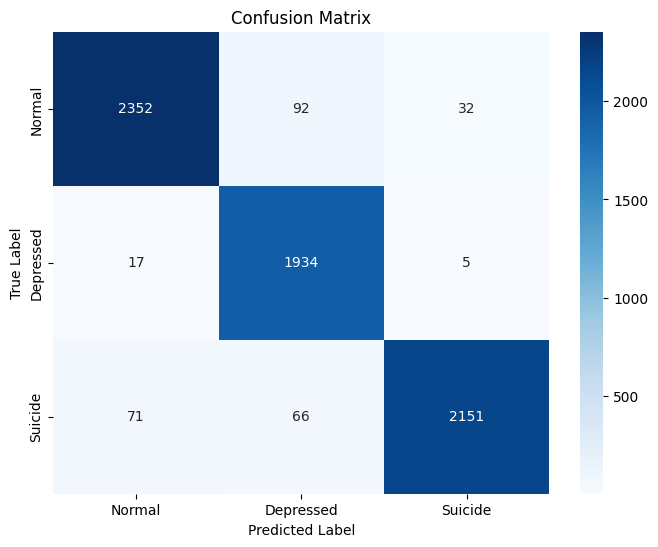

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 모델 예측 수행
y_pred = model.predict(X_test_tokenize['input_ids'])
y_pred_labels = np.argmax(y_pred.logits, axis=1)

# Confusion Matrix 생성
cm = confusion_matrix(y_test, y_pred_labels)

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Depressed', 'Suicide'], yticklabels=['Normal', 'Depressed', 'Suicide'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

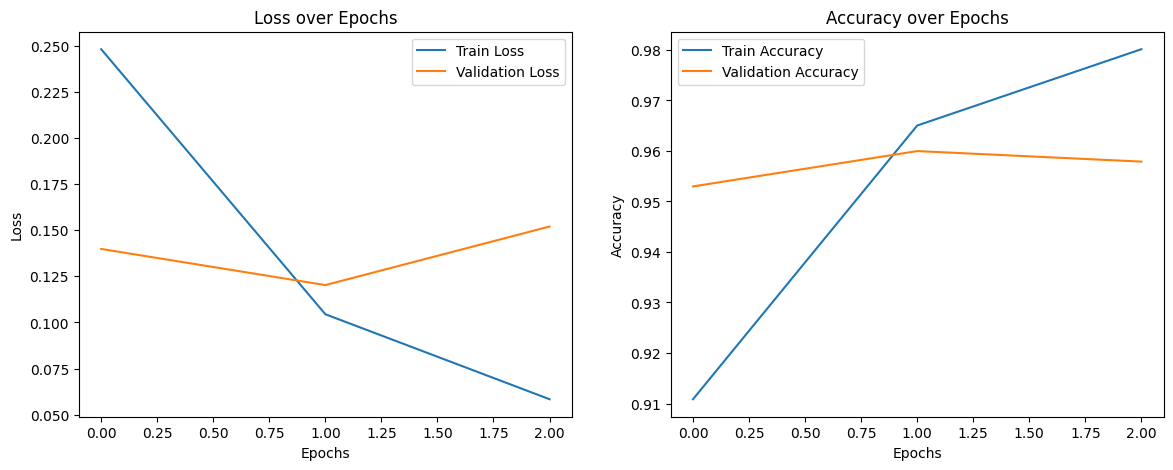

In [15]:
# 학습 손실 및 검증 손실 그래프
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 학습 정확도 및 검증 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# **예측**

In [19]:
text = ["I'm feeling pretty good today. I spent some time outdoors and enjoyed the fresh air.",
"I had a great day at work, and I'm looking forward to spending the evening with friends.",
"Life has been treating me well lately. I'm happy and content with how things are going.",
"Lately, I've been feeling very isolated. Nothing seems to bring me joy anymore.",
"It's been difficult to find motivation to do anything these days. Everything feels overwhelming.",
"I often feel like I'm just going through the motions. It's hard to find a reason to keep going.",
"I feel like there's no escape from the pain. Every day is a struggle just to get by.",
"I've been thinking that maybe it would be better if I weren't around anymore. The pain is too much.",
"Sometimes I think about ending it all. It feels like that might be the only way to find peace."]

In [20]:
example_t= tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='tf')

# 예측
pred = model.predict(example_t['input_ids'])

# 예측된 라벨
pred_labels = np.argmax(pred.logits, axis=1)

# 결과 출력
for text, label in zip(text, pred_labels):
    print(f"Text: {text} ---> Label: {label}")
    if label == 0:
        print('Normal')
    elif label == 1:
        print('Depressed')
    else:
        print('Suicide')
    print('--------------------')

1/1 [==============================] - 0s 194ms/step
Text: I'm feeling pretty good today. I spent some time outdoors and enjoyed the fresh air. ---> Label: 1
Depressed
--------------------
Text: I had a great day at work, and I'm looking forward to spending the evening with friends. ---> Label: 1
Depressed
--------------------
Text: Life has been treating me well lately. I'm happy and content with how things are going. ---> Label: 1
Depressed
--------------------
Text: Lately, I've been feeling very isolated. Nothing seems to bring me joy anymore. ---> Label: 1
Depressed
--------------------
Text: It's been difficult to find motivation to do anything these days. Everything feels overwhelming. ---> Label: 1
Depressed
--------------------
Text: I often feel like I'm just going through the motions. It's hard to find a reason to keep going. ---> Label: 1
Depressed
--------------------
Text: I feel like there's no escape from the pain. Every day is a struggle just to get by. ---> Label: 1
D